In [1]:
# Импорт необходимых библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from urllib.parse import urlencode 
from scipy.stats import norm, mannwhitneyu, ttest_ind, shapiro, levene, chi2_contingency
import statsmodels.api as sm
from datetime import datetime

%matplotlib inline

# Задача 1 — A/B-testing

## 1. Выгрузка данных

Так как данные находятся на платформе Яндекс.Диск, то воспользуемся библиотеками **requests** и **urllib** для того, чтобы получить ссылки на скачивание данных файлов и, в дальнейшем, преобразовать их в формат Датафрейма.

In [2]:
# 1.1 Создаем базовый URL

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

In [3]:
# 1.2 Создаем частный URL для каждой ссылки, предоставленной на платформе LMS

public_key_groups = 'https://disk.yandex.ru/d/58Us0DWOzuWAjg'
public_key_groups_add = 'https://disk.yandex.ru/d/3aARY-P9pfaksg'
public_key_active_studs = 'https://disk.yandex.ru/d/prbgU-rZpiXVYg'
public_key_checks = 'https://disk.yandex.ru/d/84hTmELphW2sqQ'

In [4]:
# 1.3 Соединяем предыдущие две части

final_url_groups = base_url + urlencode(dict(public_key=public_key_groups))
final_url_groups_add = base_url + urlencode(dict(public_key=public_key_groups_add))
final_url_active_studs = base_url + urlencode(dict(public_key=public_key_active_studs))
final_url_checks = base_url + urlencode(dict(public_key=public_key_checks))

In [5]:
# 1.4 Собственно создаем валидные ссылки для скачивания файлов

response_groups = requests.get(final_url_groups)
response_groups_add = requests.get(final_url_groups_add)
response_active_studs = requests.get(final_url_active_studs)
response_checks = requests.get(final_url_checks)

In [6]:
download_url_groups = response_groups.json()['href']
download_url_groups_add = response_groups_add.json()['href']
download_url_active_studs = response_active_studs.json()['href']
download_url_checks = response_checks.json()['href']

In [7]:
# 1.5 Считываем данные и преобразуем наши данные в формат пандасовского датафрейма

groups = pd.read_csv(download_url_groups, sep=';')
groups_add = pd.read_csv(download_url_groups_add)
active_studs = pd.read_csv(download_url_active_studs)
checks = pd.read_csv(download_url_checks, sep=';')

## 2. Предварительный анализ данных (EDA), преобразование в нужный вид

Перед тем, как приступить к решению задач, нужно удостовериться, что с нашими данными все в порядке. Для этого мы проведем предварительный анализ, то есть посмотрим, есть ли в наших данных пропущенные значения, дубликаты и т.д. Пройдемся по каждому файлу.

##### groups

In [8]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [9]:
groups.dtypes

id      int64
grp    object
dtype: object

In [10]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [11]:
groups.duplicated(subset=['id']).sum()

0

##### groups_add

In [12]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [13]:
groups_add.dtypes

id      int64
grp    object
dtype: object

In [14]:
groups_add.isna().sum()

id     0
grp    0
dtype: int64

In [15]:
groups_add.duplicated(subset=['id']).sum()

0

##### active_studs

In [16]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [17]:
active_studs.dtypes

student_id    int64
dtype: object

In [18]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [19]:
active_studs.duplicated().sum()

0

##### checks

In [20]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [21]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [22]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [23]:
checks.duplicated(subset=['student_id']).sum()

0

В наших данных нет ни дубликатов пользователей, ни пропущенных значений, и формат данных соответствует нужному типу. Так что можно двигаться дальше!

По условиям задачи, помимо основных данных (groups), у нас есть также дополнительные данные по пользователям (groups_add), которые пришли 2-мя днями позже. Это значит, что эти данные нужно объединить в одну таблицу.

После, у тех пользователей, которые зашли в день проведения эксперимента (active_studs) и сделали оплату (checks), мы должны узнать, к какой группе они принадлежат.

In [24]:
# 2.1 Соединяем таблицы "groups" и "groups_add"

whole_group = pd.concat([groups, groups_add], ignore_index=True)

In [25]:
whole_group.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


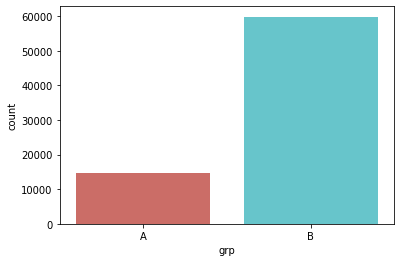

In [26]:
# 2.2 Посмотрим на количество пользователей в каждой из групп
sns.countplot(x='grp', 
              data=whole_group,
              order=['A', 'B'],
              palette='hls')

Видно, что в нашей общей выборке преимущественно пользователи из целевой группы (B).

In [27]:
# 2.3 Объединяем предыдущую таблицу с таблицей пользователей, которые зашли в день проведения эксперимента

active_studs_with_groups = active_studs.merge(whole_group, 
                                  left_on='student_id',
                                  right_on='id',
                                  how='left')

active_studs_with_groups = active_studs_with_groups.drop('id', axis=1)

In [28]:
active_studs_with_groups.isna().sum()

student_id    0
grp           0
dtype: int64

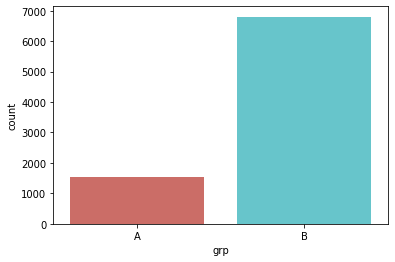

In [29]:
# 2.4 Посмотрим на распределение пользователей по группам в день проведения эксперимента
sns.countplot(x='grp', 
              data=active_studs_with_groups,
              palette='hls')

Также можем посмотреть, насколько различны распределения групп в общей выборке и в день проведения эксперимента.

In [30]:
whole_group.grp.value_counts(normalize=True)

B    0.80298
A    0.19702
Name: grp, dtype: float64

In [31]:
active_studs_with_groups.grp.value_counts(normalize=True)

B    0.81561
A    0.18439
Name: grp, dtype: float64

Как видим, распределение групп практически не изменилось, то есть отношение количества людей в контрольной группе к целевой группе сохранилось в день проведения эксперимента.

In [32]:
# 2.5 Объединяем таблицу active_studs_with_groups с таблицей checks

paid_users = active_studs_with_groups.merge(checks, 
                                            on='student_id')

В данном случае мы мёрджим по inner join, так как в таблице checks есть данные по пользователям, которые не попали ни в контрольную, ни в целевую группы. Поэтому количество наблюдений в результирующей таблице будет не 541 (как в таблице checks), а меньше (в нашем случае 392).

In [33]:
paid_users.shape

(392, 3)

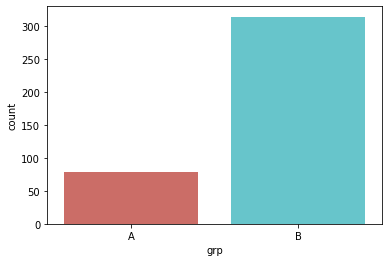

In [34]:
# 2.6 Посмотрим на соотношение количества пользователей в двух группах

sns.countplot(x='grp',
              data=paid_users,
              palette='hls')

In [35]:
paid_users.grp.value_counts(normalize=True)

B    0.80102
A    0.19898
Name: grp, dtype: float64

Соотношение количества пользователей, которые в день проведения эксперимента сделали покупку, в контрольной и тестовой группах осталось практически таким же.

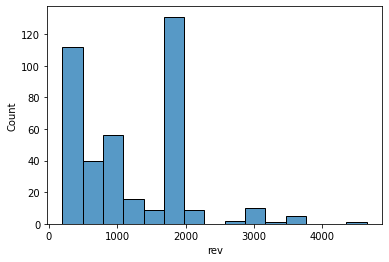

In [36]:
# 2.7 Построим гистограмму суммы покупок

sns.histplot(x='rev',
             data=paid_users,
             bins=15)

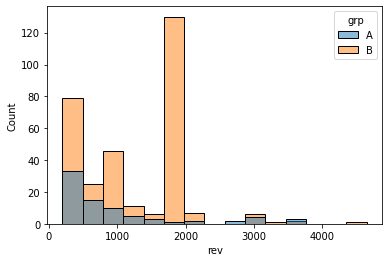

In [37]:
# 2.8 Построим такую же гистограмму суммы покупок, НО с разделением на группы

sns.histplot(x='rev',
             data=paid_users,
             hue='grp',
             bins=15)

Что на первой, что на второй гистограмме мы видим, что наши распределения далеки от нормального. 

Также бросается в глаза то, что в нашей тестовой группе довольно много пользователей совершивших покупку на сумму в районе 1700-2000 руб. Это мы также можем проверить с помощью метода value_counts().

In [38]:
paid_users[paid_users['grp'] == 'B'].rev.value_counts(bins=15).head(5)

(1682.667, 1979.4]    130
(194.548, 495.733]     79
(792.467, 1089.2]      46
(495.733, 792.467]     25
(1089.2, 1385.933]     11
Name: rev, dtype: int64

## 3. Выбор метрики для тестирования, определение нулевой гипотезы, выбор критерия оценки

После того, как мы взглянули на наши данные и привели их в нужный нам вид, мы должны определить:

1. Какую **метрику** мы будем сравнивать\тестировать?

2. Как звучит **нулевая гипотеза** для тестирования данной метрики?

3. Какой **статистический критерий** нужно выбрать для данного эксперимента?

Этого нужно для того, чтобы ответить на вопрос:

<i>Является ли новая механика оплаты услуг на сайте более эффективной? Если да, то как именно она влияет?</i>

#### Возможные варианты

1. Расчет **конверсии во вхождение на сайт в день проведения эксперимента** является бессмысленной, так как кажется, что установка новой системы оплаты не должна влиять на то, зайдет ли человек на сайт или нет. 

<i>P.S. Есть небольшая вероятность того, что человеку может понравиться новая система оплаты, и это заставит его заходить чаще. Однако, это уже другой вопрос.</i>

2. Расчет **конверсии из вхождения на сайт в покупку** кажется довольно целесообразной метрикой для сравнения. Для этого мы можем использовать критерий **Хи-квадрат** и сформулировать нулевую гипотезу следующим образом: 
<blockquote>Наши переменные (конверсии) в двух группах независимы, и распределение значений в этих группах относительно одинаковые</blockquote>

3. Сравнение **среднего значения суммы покупки для двух групп, включающих в себя только платящих пользователей**. Тем самым, мы сравниваем <i>ARPPU</i> в контрольной и тестовой группе. Здесь можно использовать несколько критериев (гипотезы будут отличаться, однако они применимы для нашего кейса, при условии, что соблюдаются требования к их применению). Однако, как будет показано дальше, я выберу метод **Bootstrap**, так как для t-критерия Стьюдента соблюдаются не все условия, что может привести к не самым точным результатам. По итогу наша нулевая гипотеза будет следующая:
<blockquote>Средние значения суммы покупок для платящих пользователей в двух группах не отличаются</blockquote>

4. Также можно сделать сравнение **среднего значения суммы покупки для двух групп, учитывая всех пользователей, участвовавших в день проведения эксперимента**. То есть, мы будем сравнивать <i>ARPU</i>.

#### 3.1 Конверсия из вхождения в покупку (CR_pay)

Для этого нам пригодится таблица <i>active_studs_with_groups</i>, в которой хранятся данные по пользователей, которые зашли в день эксперимента, и их группы. Также в таблице <i>checks</i> создадим колонку с единицами, которая означает совершение покупки.

In [39]:
active_studs_with_groups.head()

,student_id,grp
0,581585,A
1,5723133,A
2,3276743,B
3,4238589,A
4,4475369,B


In [40]:
# 3.1.1 Добавим столбец с единицами

checks['is_paid'] = 1 

In [41]:
checks.head()

,student_id,rev,is_paid
0,1627,990.0,1
1,3185,690.0,1
2,25973,690.0,1
3,26280,690.0,1
4,100300,990.0,1


In [42]:
# 3.1.2 Создадим общую таблицу, в которой указаны номера студентов и сумма их покупок.
# В данном случае мы делаем 'left join', чтобы у тех студентов, которые были в день эксперимента, но ничего не покупали, было
# значение NaN. Далее мы их заменим на 0.

paid_studs_for_cr = active_studs_with_groups.merge(checks[['student_id', 'is_paid']],
                                                on='student_id',
                                                how='left')

In [43]:
paid_studs_for_cr = paid_studs_for_cr.fillna(0)
paid_studs_for_cr['is_paid'] = paid_studs_for_cr['is_paid'].astype('int')

In [44]:
paid_studs_for_cr.head()

,student_id,grp,is_paid
0,581585,A,0
1,5723133,A,0
2,3276743,B,0
3,4238589,A,0
4,4475369,B,0


In [45]:
# 3.1.3 Посмотрим на распределение пользователей на купивших-некупивших в двух группах
# '1' — была покупка, '0' - покупки не было

paid_studs_for_cr.groupby('grp').is_paid.value_counts()

grp  is_paid
A    0          1460
     1            78
B    0          6489
     1           314
Name: is_paid, dtype: int64

In [46]:
# 3.1.4 Разделим нашу таблицу на группу А и В

grp_A = paid_studs_for_cr[paid_studs_for_cr['grp'] == 'A']
grp_B = paid_studs_for_cr[paid_studs_for_cr['grp'] == 'B']

In [47]:
# 3.1.5 Введем переменные, где укажем количество купивших и не купивших в каждой из групп

grp_A_pay = grp_A.is_paid.sum()
grp_A_no_pay = grp_A.is_paid.size - grp_A.is_paid.sum()
grp_B_pay = grp_B.is_paid.sum()
grp_B_no_pay = grp_B.is_paid.size - grp_B.is_paid.sum()

In [48]:
print(grp_A_pay)
print(grp_A_no_pay)
print(grp_B_pay)
print(grp_B_no_pay)

78
1460
314
6489


In [49]:
# 3.1.6 Создадим матрицу с нашими значениями

CR_pay_matrix = np.array([[grp_A_pay, grp_A_no_pay],
                          [grp_B_pay, grp_B_no_pay]])

In [50]:
CR_pay_matrix

array([[  78, 1460],
       [ 314, 6489]])

In [51]:
# 3.1.7 Проверим наши данные по критерию Хи-квадрат

print(chi2_contingency(CR_pay_matrix, correction=False)[1])

0.44547028437158964


По результату критерия **Хи-квадрат** (берем уровень альфа, равным 5%), мы не можем отклонить нулевую гипотезу, что наши конверсии в 2-х группах независимы и их распределения относительно одинаковы. Это значит, что скорее всего, новая механика не влияет на то, решится ли пользователь что-то купить или нет.

#### 3.2 Среднее значение суммы покупки для двух групп, включающих в себя только платящих пользователей (ARPPU)

Первым делом стоит взглянуть на соотношение наших значений.


In [52]:
paid_users.head()

,student_id,grp,rev
0,1184303,A,1530.0000
1,3354191,B,1900.0001
2,3278734,B,1900.0000
3,720651,A,1980.0000
4,1232221,B,1900.0000


In [53]:
paid_users.grp.value_counts()

B    314
A     78
Name: grp, dtype: int64

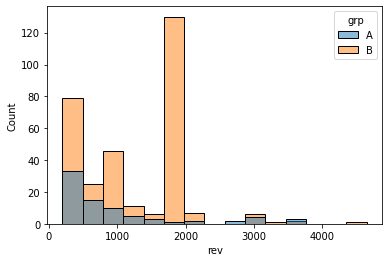

In [54]:
# 3.2.1 Построим гистограмму как в предыдущий раз

sns.histplot(x='rev', 
             data=paid_users, 
             hue='grp', 
             bins=15)

Уже на гистограммах наших значений заметно, что ни в тестовой, ни в контрольной группах распределение не близко к нормальному, что уже ставит под сомнение выбор **t-теста**.

Утверждают, что при большой выборке данным требованием можно пренебречь. Однако, наших данных не так то много (392 наблюдений).

In [55]:
# 3.2.2 Создаем выборки с тестовой и контрольной группами

control_grp = paid_users[paid_users['grp'] == 'A'].rev
test_grp = paid_users[paid_users['grp'] == 'B'].rev

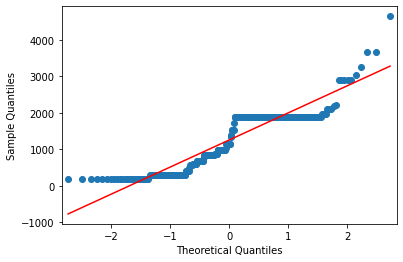

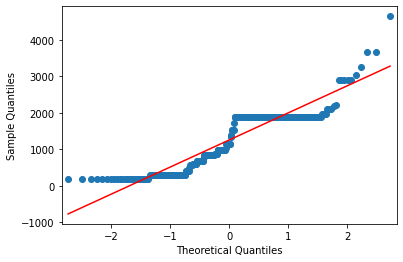

In [56]:
# 3.2.3 Построим график QQ-plot для двух выборок

sm.qqplot(test_grp, line='r')

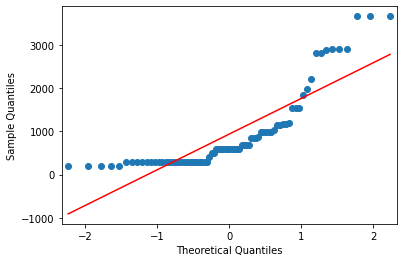

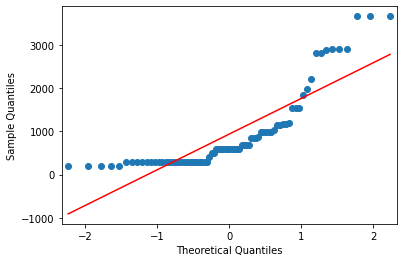

In [57]:
sm.qqplot(control_grp, line='r')

In [58]:
# 3.2.4 Посмотрим, что покажет тест Шапиро-Уилко на нормальность

print(shapiro(control_grp))
print(shapiro(test_grp))

ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)
ShapiroResult(statistic=0.8547235727310181, pvalue=1.5437024585965894e-16)


Мы видим, что, как на графиках qq-plot, так и при тесте Шапиро, результаты ведут к тому, что распределения наших обоих выборок не близко к нормальному.

In [59]:
# 3.2.5 Проверим требование к гомогенности дисперсий

levene(control_grp, test_grp)

LeveneResult(statistic=3.0756816999816055, pvalue=0.08025675761347022)

Так как требования к **t-тесту** практически не соблюдаются, то целесообразно будет использовать либо непараметрический аналог **t-теста**, а именно **критерий Манна-Уитни**, либо **Бутстрап**.

Я бы предпочел использовать **Бутстрап**, так как, с точки зрения бизнеса, результат **Манна-Уитни** тяжело интерпретировать.

In [60]:
# 3.2.6 Напишем функцию Бутстрапа

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_iter = 2000, # количество бутстрап-выборок
    statistic = np.mean, # интересующая статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max(len(data_column_1), len(data_column_2))
    boot_data = []
    for i in range(boot_iter): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len,
            replace=True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len,
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
    
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
    
    p_1 = norm.cdf(
        x = 0,
        loc = np.mean(boot_data),
        scale = np.std(boot_data))
    
    p_2 = norm.cdf(
        x = 0,
        loc = -np.mean(boot_data),
        scale = np.std(boot_data))
    
    p_value = min(p_1, p_2) * 2
    
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title('Histogram of boot_data')
    plt.show()
    
    return {'boot_data': boot_data,
            'ci': ci,
            'p_value': p_value}

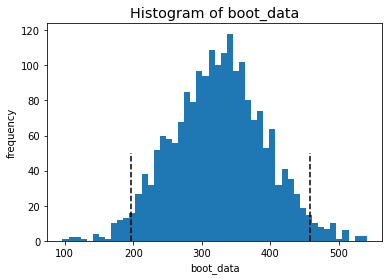

In [61]:
# 3.2.7 Инициализируем наш Бутстрап

boot_test = get_bootstrap(test_grp, control_grp, boot_iter=2000)

In [62]:
# 3.2.8 Посмотрим на наши доверительные интервалы

boot_test['ci']

,0
0.025,196.852161
0.975,458.671189


In [63]:
# 3.2.9 Взглянем на p-value

boot_test['p_value']

1.7862748262696082e-06

Так как p-значение значительно меньше 0.05 и в доверительные интервалы не входит 0, мы можем сказать, что различия в средних наших выборок есть и они стат.значимы. С точки зрения бизнеса, это можно интерпретировать, как то, что наша новая механика оплаты влияет на то, сколько пользователь решит потратить на покупку.

Для интереса, также взглянем на результат теста Манна-Уитни

In [64]:
# 3.2.10 Тест Манна-Уитни так же показывает стат.значимое различие

mannwhitneyu(control_grp, test_grp)

MannwhitneyuResult(statistic=9001.0, pvalue=0.0002511393831406922)

Результат U-теста Манна-Уитни показывает, что, скорее всего, распределения суммы покупок наших двух групп не совпадают, и это разница стат.значима.

#### 3.3 Среднее значение суммы покупки для двух групп, учитывая всех пользователей, участвовавших в день проведения эксперимента (ARPU)

В данном случае нам нужно завести новую таблицу, которая будет учитывать всех пользователей, вошедших на сайт в день проведения эксперимента, и сумму их покупок (если пользователь ничего не купил, то его сумма покупок будет 0).

In [65]:
# 3.3.1 Создадим новую таблицу и заполним значения NaN нулями

users_for_arpu = active_studs_with_groups.merge(checks[['student_id', 'rev']],
                                                on='student_id',
                                                how='left')

users_for_arpu = users_for_arpu.fillna(0)

In [66]:
users_for_arpu.head()

,student_id,grp,rev
0,581585,A,0.0
1,5723133,A,0.0
2,3276743,B,0.0
3,4238589,A,0.0
4,4475369,B,0.0


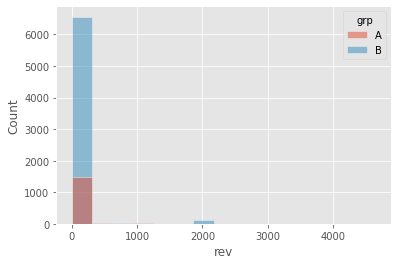

In [67]:
# 3.3.2 Посмотрим на распределение суммы покупок в обеих группах

sns.histplot(x='rev',
             data=users_for_arpu,
             hue='grp',
             bins=15)

После того, как мы соединили таблицы *active_studs_with_groups* и *checks*, в нашей гистограмме стало заметно больше "непокупок". Это значит, что, на самом деле, очень незначительное количество пользователей (и с контрольной, и с тестовой группы) совершили покупку в день эксперимента.

В любом случае, разделим наши данные на 2 группы и проверим результат по **bootstrap**.

In [68]:
# 3.3.3 Разделим данные на группу А и В

control_group_2 = users_for_arpu[users_for_arpu['grp'] == 'A'].rev
test_group_2 = users_for_arpu[users_for_arpu['grp'] == 'B'].rev

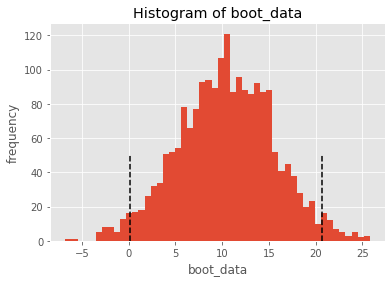

In [69]:
# 3.3.4 Проведем бутстрап по этим выборкам

boot_test_2 = get_bootstrap(test_group_2, control_group_2, 
                            boot_iter=2000)

In [70]:
# 3.3.5 Посмотрим на наши доверительные интервалы

boot_test_2['ci']

,0
0.025,0.102169
0.975,20.679241


In [71]:
# 3.3.6 Взглянем на p-value

boot_test_2['p_value']

0.04073209251727244

Как мы видим, в доверительный интервал не входит нулевое значение, хотя оно и довольно близко. Также p-value показывает результат ниже 5%, что позволяет нам утверждать, что средние в двух группах отличаются стат.значимо.

### Итог по задаче 1:

Мы провели предварительный анализ наших данных. В наших данных не было никаких дефектов, поэтому мы сразу приступили к следующей части. Мы обработали данные и привели их в нужный для нас вид.

Для сравнения и тестирования мы решили взять такие показатели, как **CR в покупку, ARPPU** и **ARPU**. При тестировании **конверсии** с помощью критерия *Хи-квадрат* результат не дал стат.значимых различий. Однако, при сравнении **ARPPU** и **ARPU** мы получили результат, который показывает, что эти показатели стат.значимо отличаются в контрольной и тестовой группах.



В результате, мы можем утвердить новую механику оплаты услуг на сайте и ожидать, что благодаря ней мы сможем увеличить средний чек наших покупателей.

# Задача 2 — SQL

##### 2.1 Усердные ученики

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

In [75]:
"""
SELECT
    COUNT(*)
FROM
    (SELECT 
        st_id,
        SUM(correct)
    FROM peas
    WHERE
        toStartOfMonth(timest) == toStartOfMonth(now())
    GROUP BY
        st_id
    HAVING
        SUM(correct) >= 20)
"""

'\nSELECT\n    COUNT(*)\nFROM\n    (SELECT \n        st_id,\n        SUM(correct)\n    FROM peas\n    WHERE\n        toStartOfMonth(timest) == toStartOfMonth(now())\n    GROUP BY\n        st_id\n    HAVING\n        SUM(correct) >= 20)\n'

##### 2.2 Оптимизация воронки

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- ARPU

- ARPAU

- CR в покупку

- СR активного пользователя в покупку 

- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [1]:
'''
SELECT
    test_grp,
    sum(total_revenue) / uniqExact(st_id) as ARPU,
    sumIf(total_revenue, active_stud=1) / uniqExactIf(st_id, active_stud=1) as ARPAU,
    uniqExactIf(st_id, total_revenue > 0) / uniqExact(st_id) as CR_to_buy,
    uniqExactIf(st_id, active_stud=1 and total_revenue>0) / uniqExactIf(st_id, active_stud=1) as CR_active_to_buy,
    uniqExactIf(st_id, math_active_stud=1 and math_revenue>0) / uniqExactIf(st_id, math_active_stud=1) as CR_math_active_to_buy_math
FROM
    (
    SELECT 
        l.test_grp as test_grp,
        l.st_id as st_id,
        r.active_stud as active_stud,
        r.math_active_stud as math_active_stud,
        r.total_revenue as total_revenue,
        r.math_revenue as math_revenue
    FROM
        (
        SELECT
            test_grp,
            st_id
        FROM studs
        ) as l
    LEFT JOIN
        (
        SELECT
            l.st_id as st_id,
            l.active_stud as active_stud,
            l.math_active_stud as math_active_stud,
            r.total_revenue as total_revenue,
            r.math_revenue as math_revenue
        FROM
            (
            SELECT
                st_id,
                if (sum(correct) > 10, 1, 0) as active_stud,
                if (sumIf(correct, subject='Math') >= 2, 1, 0) as math_active_stud
            FROM peas
            GROUP BY
                st_id
            ) as l
        LEFT JOIN
            (
            select
                st_id,
                sum(money) as total_revenue,
                sumIf(money, subject='Math') as math_revenue
            from final_project_check
            group by st_id
            ) as r
        ON l.st_id = r.st_id
        ) as r
    ON l.st_id = r.st_id
    )
GROUP BY
    test_grp
'''

"\nSELECT\n    test_grp,\n    sum(total_revenue) / uniqExact(st_id) as ARPU,\n    sumIf(total_revenue, active_stud=1) / uniqExactIf(st_id, active_stud=1) as ARPAU,\n    uniqExactIf(st_id, total_revenue > 0) / uniqExact(st_id) as CR_to_buy,\n    uniqExactIf(st_id, active_stud=1 and total_revenue>0) / uniqExactIf(st_id, active_stud=1) as CR_active_to_buy,\n    uniqExactIf(st_id, math_active_stud=1 and math_revenue>0) / uniqExactIf(st_id, math_active_stud=1) as CR_math_active_to_buy_math\nFROM\n    (\n    SELECT \n        l.test_grp as test_grp,\n        l.st_id as st_id,\n        r.active_stud as active_stud,\n        r.math_active_stud as math_active_stud,\n        r.total_revenue as total_revenue,\n        r.math_revenue as math_revenue\n    FROM\n        (\n        SELECT\n            test_grp,\n            st_id\n        FROM studs\n        ) as l\n    LEFT JOIN\n        (\n        SELECT\n            l.st_id as st_id,\n            l.active_stud as active_stud,\n            l.math_ac

# Задача 3 — Python Function

##### Условие:

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла *groups_add.csv* (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [144]:
def update_metrics(initial_df, new_df):
    
    # Заменим названия колонок на случае, если они не совпадают с стандартными названиями
    new_columns = {new_df.columns[0]: 'id',
                   new_df.columns[1]: 'grp'}
    new_df = new_df.rename(columns=new_columns)
    
    # Соединим изначальную таблицу с новой
    total_df = pd.concat([initial_df, new_df])
    
    # Сделаем копию таблицы вошедших в день эксперимента пользователей с их группами
    active_studs_w_grps = active_studs_with_groups.copy()
    active_studs_w_grps = active_studs_w_grps.rename(columns={'student_id': 'id'})
    active_studs_w_grps['is_entry'] = 1
    
    # Создадим общую таблицу для расчета конверсии в открытие сайта
    CR_entry_df = total_df.merge(active_studs_w_grps,
                                 on=['id', 'grp'],
                                 how='left')
    CR_entry_df = CR_entry_df.fillna(0)
    CR_entry_df['is_entry'] = CR_entry_df['is_entry'].astype('int')
    
    # Разделим данные на контрольную и тестовую группу
    a_cr_entry = CR_entry_df[CR_entry_df['grp'] == 'A']
    b_cr_entry = CR_entry_df[CR_entry_df['grp'] == 'B']
    
    # Посчитаем CR в открытие сайта для обеих групп
    a_cr_entry_yes = a_cr_entry.is_entry.sum()
    a_cr_entry_no = a_cr_entry.is_entry.size - a_cr_entry.is_entry.sum()
    b_cr_entry_yes = b_cr_entry.is_entry.sum()
    b_cr_entry_no = b_cr_entry.is_entry.size - b_cr_entry.is_entry.sum()
    
    a_cr_entry_result = round(a_cr_entry_yes / (a_cr_entry_yes + a_cr_entry_no) * 100, 3)
    b_cr_entry_result = round(b_cr_entry_yes / (b_cr_entry_yes + b_cr_entry_no) * 100, 3)
    
    #Создадим таблицу для расчета CR в покупку
    CR_pay_active_studs = active_studs.merge(total_df,
                                   left_on='student_id',
                                   right_on='id')
    CR_pay_active_studs = CR_pay_active_studs.drop('id', axis=1)
    
    checks_for_CR_pay = checks.copy()
    checks_for_CR_pay = checks_for_CR_pay.merge(total_df,
                                            left_on='student_id',
                                            right_on='id',
                                            how='left')
    checks_for_CR_pay = checks_for_CR_pay.drop(['rev', 'id'], axis=1)
    
    CR_pay_df = CR_pay_active_studs.merge(checks_for_CR_pay,
                                          on=['student_id', 'grp'],
                                          how='left')
    CR_pay_df = CR_pay_df.fillna(0)
    CR_pay_df['is_paid'] = CR_pay_df['is_paid'].astype('int')
    
    # Посчитаем значения СR в покупку для обеих групп
    a_cr_pay = CR_pay_df[CR_pay_df['grp'] == 'A']
    b_cr_pay = CR_pay_df[CR_pay_df['grp'] == 'B']
    
    a_cr_pay_yes = a_cr_pay.is_paid.sum()
    a_cr_pay_no = a_cr_pay.is_paid.size - a_cr_pay.is_paid.sum()
    b_cr_pay_yes = b_cr_pay.is_paid.sum()
    b_cr_pay_no = b_cr_pay.is_paid.size - b_cr_pay.is_paid.sum()
    
    a_cr_pay_result = round(a_cr_pay_yes / (a_cr_pay_yes + a_cr_pay_no) * 100, 3)
    b_cr_pay_result = round(b_cr_pay_yes / (b_cr_pay_yes + b_cr_pay_no) * 100, 3)
    
    
    # Создадим таблицу для расчета ARPPU
    checks_for_metrics = checks.copy()
    checks_for_metrics = checks_for_metrics.rename(columns={'student_id': 'id'})
    checks_for_metrics = checks_for_metrics[['id', 'rev']]
    active_studs_with_grp_rev = active_studs_w_grps.drop('is_entry', axis=1).merge(checks_for_metrics,
                                                                                   on='id',
                                                                                   how='inner')
    
    # Посчитаем значения ARPPU для обеих групп
    ARPPU_df_grp_A = active_studs_with_grp_rev[active_studs_with_grp_rev['grp'] == 'A']
    ARPPU_df_grp_B = active_studs_with_grp_rev[active_studs_with_grp_rev['grp'] == 'B']
    ARPPU_grp_A_result = round(ARPPU_df_grp_A.rev.sum() / ARPPU_df_grp_A.rev.size, 2)
    ARPPU_grp_B_result = round(ARPPU_df_grp_B.rev.sum() / ARPPU_df_grp_B.rev.size, 2)
    
    #Создадим таблицу для расчета ARPU
    ARPU_df = total_df.merge(active_studs_with_grp_rev,
                             on=['id', 'grp'],
                             how='left')
    ARPU_df = ARPU_df.fillna(0)
    
    #Посчитаем ARPU для обеих групп
    ARPU_df_grp_A = ARPU_df[ARPU_df['grp'] == 'A']
    ARPU_df_grp_B = ARPU_df[ARPU_df['grp'] == 'B']
    ARPU_grp_A_result =  round(ARPU_df_grp_A.rev.sum() / ARPU_df_grp_A.rev.size, 2)
    ARPU_grp_B_result =  round(ARPU_df_grp_B.rev.sum() / ARPU_df_grp_B.rev.size, 2)
    
    print(f'Конверсия в открытие сайта для контрольной (А) группы: {a_cr_entry_result} %')
    print(f'Конверсия в открытие сайта для тестовой (В) группы: {b_cr_entry_result} %'+'\n')
    print(f'Конверсия в покупку для контрольной (А) группы: {a_cr_pay_result} %')
    print(f'Конверсия в покупку для тестовой (В) группы: {b_cr_pay_result} %'+'\n')
    print(f'ARPPU для контрольной(А) группы: {ARPPU_grp_A_result}')
    print(f'ARPPU для тестовой(B) группы: {ARPPU_grp_B_result}'+'\n')
    print(f'ARPU для контрольной(А) группы: {ARPU_grp_A_result}')
    print(f'ARPU для тестовой(В) группы: {ARPU_grp_B_result}')
    
    return {'Group': ['A', 'B'],
            'CR (to entry), %': [a_cr_entry_result, b_cr_entry_result],
            'CR (to buy), %': [a_cr_pay_result, b_cr_pay_result],
            'ARPPU': [ARPPU_grp_A_result, ARPPU_grp_B_result],
            'ARPU': [ARPU_grp_A_result, ARPU_grp_B_result]}    

Функцию для построения графиков будет написана таким образом, что для нее ожидается вход словаря (в виде выхода функции **update_metrics**)

In [150]:
def plot_metrics(df_with_metrics):
    
    # В функцию подаем словарь с нашими значениями метрик для контрольной и тестовой групп
    plot_df = pd.DataFrame(df_with_metrics)
    
    sns.set_context('poster')
    fig, axes = plt.subplots(1, 4, sharex=True, figsize=(10, 5))
    plt.tight_layout()
    fig.suptitle(f'Metrics review as of {datetime.now().strftime("%Y-%m-%d %H:%M")}')

    sns.scatterplot(ax=axes[0], y='CR (to entry), %', x='Group', data=plot_df, hue='Group', legend=False)
    
    sns.scatterplot(ax=axes[1], y='CR (to buy), %', x='Group', data=plot_df, hue='Group', legend=False)

    sns.scatterplot(ax=axes[2], y='ARPPU', x='Group', data=plot_df, hue='Group', legend=False)

    sns.scatterplot(ax=axes[3], y='ARPU', x='Group', data=plot_df, hue='Group', legend=False)

Проверим на наших таблицах *groups* и *groups_add*

Конверсия в открытие сайта для контрольной (А) группы: 10.468 %
Конверсия в открытие сайта для тестовой (В) группы: 11.36 %

Конверсия в покупку для контрольной (А) группы: 5.072 %
Конверсия в покупку для тестовой (В) группы: 4.616 %

ARPPU для контрольной(А) группы: 933.59
ARPPU для тестовой(B) группы: 1257.88

ARPU для контрольной(А) группы: 4.96
ARPU для тестовой(В) группы: 6.6


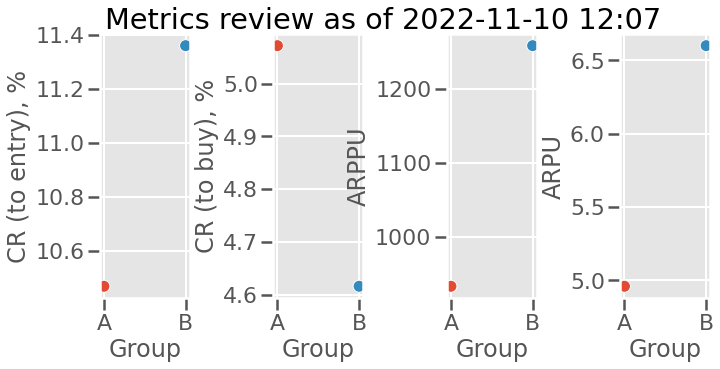

In [151]:
plot_metrics(update_metrics(groups, groups_add))